In [1]:
import joblib
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# load the model
model = joblib.load('model/best_LGB_10k_Undersampled_BestParams.pkl')

#load the X_train dataframe
df = pd.read_pickle('../data/cleaned/client_data_api_dashboard.pkl')

# load full data
full_data = pd.read_csv('../data/raw/application_train.csv')

# annuity (loan interest)
df_AMT_ANNUITY = pd.read_pickle('../data/cleaned/df_amt_annuity.pkl')

In [3]:
df = df.join(df_AMT_ANNUITY)

In [4]:
df.AMT_ANNUITY.isna().sum()

0

In [5]:
def get_Xy_full(df):
    X = df.drop(columns=['TARGET','AMT_ANNUITY'])
    y = df.TARGET
    return X, y

In [6]:
X, y = get_Xy_full(df)

# 1

In [7]:
N_SAMPLES = df.shape[0]
N_THRESHOLDS = 40
CLASS_1_RATIO = df[df.TARGET==1].shape[0] / df[df.TARGET==0].shape[0]

# ndarray
y_true = df.TARGET.values

# ndarray
y_pred = model.predict_proba(X)[:,1]

THRESHOLDS = [ i/float(N_THRESHOLDS) for i in range(N_THRESHOLDS+1) ]

In [8]:
CLASS_1_RATIO

0.08781828601345662

# 2

In [9]:
def cm(y_true, y_pred, threshold=0.5):
    return confusion_matrix(
        y_true,
        y_pred>=threshold
    )
def confusion_curve(y_true, y_pred):
    return [
        cm(y_true, y_pred, thr).flatten()
        for thr in THRESHOLDS
    ]

print("Confusion matrix at 50%:\n", cm(y_true, y_pred))

Confusion matrix at 50%:
 [[196704  85982]
 [  7511  17314]]


# 3

In [10]:
CURVES = pd.DataFrame(
    confusion_curve(y_true, y_pred),
    columns = [ 'TN', 'FP', 'FN', 'TP', ]
) / N_SAMPLES  # Normalized per sample

CURVES['threshold'] = THRESHOLDS

# 4

In [11]:
# W0 = volume of interests that are paid back
# W1 = estimation of the averaged capital lost for bad customers
# if W1/W0 penalty is lower than (1/class1ratio - 1) then gains are always positive
#    (8% => W1/W0 = 11.5)
# but it doesn't mean maximal gain at any threshold!!
# W0 =  27108.0  # average loan value
# W1 = 599025.0  # avergae annuity value
################
W0 =  27108  # penalty=12.5
W1 =  599026  #
################


CURVES['EARNED']     = W0*CURVES.TN
CURVES['NOT_EARNED'] = W0*CURVES.FP
CURVES['LOST']       = W1*CURVES.FN
CURVES['NOT_LOST']   = W1*CURVES.TP
CURVES['GAIN']       = CURVES.EARNED - CURVES.LOST
CURVES['THEORY_GAIN']= CURVES.EARNED + CURVES.NOT_EARNED
CURVES['MAX_GAIN']   = W0
CURVES["CONSTANT_COST"]  = - W0*CURVES.TP[0]
CURVES["REJECTING_COST"] = - CURVES.NOT_EARNED
CURVES["ACCEPTING_COST"] = - CURVES.LOST
CURVES["MINUS_EARNED"]   = - CURVES.GAIN


In [12]:
CURVES.to_pickle('../data/cleaned/curves_new.pkl')

In [13]:

COLORS = {}
def add_color(color, keys):
    for key in keys:
        COLORS[key] = color
add_color("green" , ["TN", "EARNED"    , "GAIN"       , "MINUS_EARNED"  , ])
add_color("blue"  , ["TP", "NOT_LOST"  , "MAX_GAIN"   , "CONSTANT_COST" , ])
add_color("red"   , ["FN", "LOST"      ,                "ACCEPTING_COST", ])
add_color("orange", ["FP", "NOT_EARNED", "THEORY_GAIN", "REJECTING_COST", ])

COMMON_GRAPH_OPTIONS = dict(
    x='threshold',
    color=COLORS,
)

# MEDIUM RISK

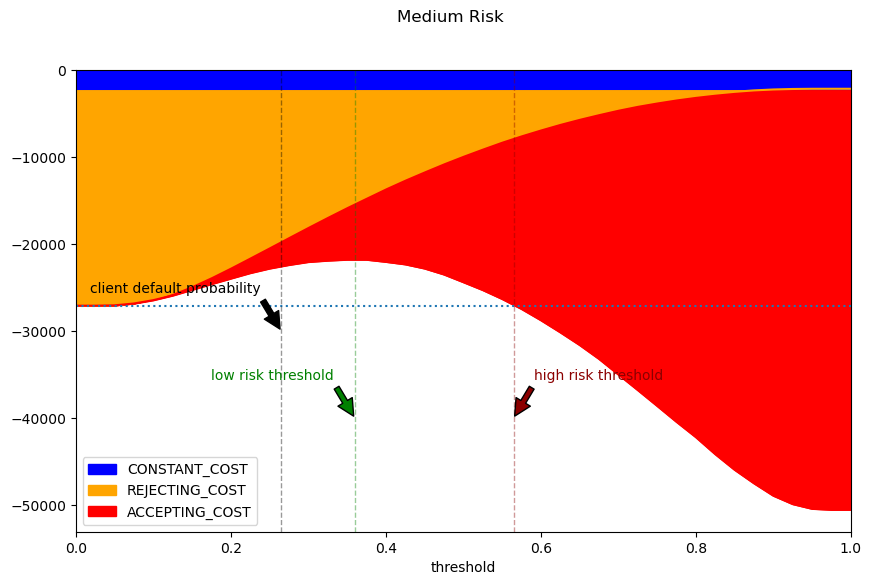

In [45]:
# normal risk

fig, ax = plt.subplots(figsize =(10, 6))

MAX_GAIN = W0
MAX_LOST = (W1+W0)*CLASS_1_RATIO
MARGIN = 0.05*(MAX_GAIN+MAX_LOST)
CURVES.plot.area(
    ax=ax,
    y=['CONSTANT_COST', 'REJECTING_COST', 'ACCEPTING_COST', ],
    stacked=True,
    **COMMON_GRAPH_OPTIONS
)
ax.plot([0, 1],[-W0, -W0], ':')
ax.set_xlim(0,1)
ax.legend(loc='lower left')

plt.axvline(x=0.360, ymin=0, ymax=1, color='green', linestyle='--', linewidth=1, alpha=0.4)
plt.axvline(x=0.565, ymin=0, ymax=1, color='darkred', linestyle='--', linewidth=1, alpha=0.4)
plt.axvline(x=0.265, ymin=0, ymax=1, color='black', linestyle='--', linewidth=1, alpha=0.4)

ax.annotate('low risk threshold',
            xy=(0.360, -40000), xycoords='data', color='green',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='green', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

ax.annotate('high risk threshold',
            xy=(0.565, -40000), xycoords='data', color='darkred',
            xytext=(15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='darkred', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom')

ax.annotate('client default probability',
            xy=(0.265, -30000), xycoords='data', color='black',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

plt.suptitle('Medium Risk')
plt.show()

# LOW RISK

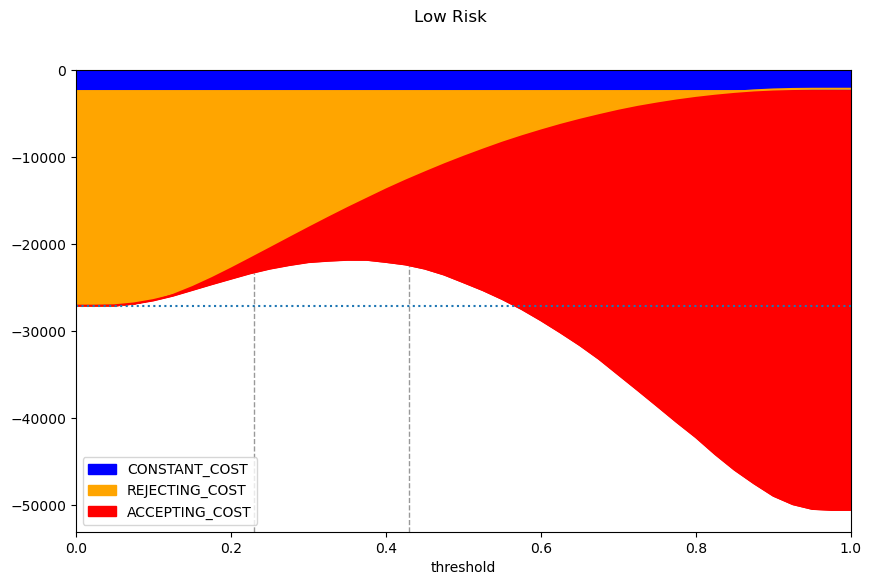

In [27]:
# low risk

fig, ax = plt.subplots(figsize =(10, 6))

MAX_GAIN = W0
MAX_LOST = (W1+W0)*CLASS_1_RATIO
MARGIN = 0.05*(MAX_GAIN+MAX_LOST)
CURVES.plot.area(
    ax=ax,
    y=['CONSTANT_COST', 'REJECTING_COST', 'ACCEPTING_COST', ],
    stacked=True,
    **COMMON_GRAPH_OPTIONS
)
ax.plot([0, 1],[-W0, -W0], ':')
ax.set_xlim(0,1)
ax.legend(loc='lower left')

plt.axvline(x=0.230, ymin=0, ymax=0.559, color='black', linestyle='--', linewidth=1, alpha=0.4)
plt.axvline(x=0.430, ymin=0, ymax=0.575, color='black', linestyle='--', linewidth=1, alpha=0.4)
plt.suptitle('Low Risk')
plt.show()

# HIGH RISK

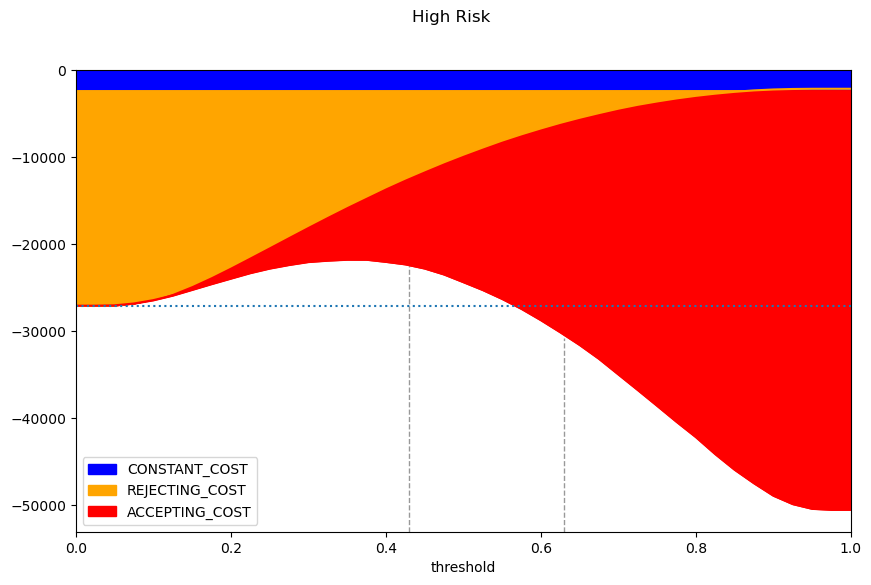

In [31]:
# high risk

fig, ax = plt.subplots(figsize =(10, 6))

MAX_GAIN = W0
MAX_LOST = (W1+W0)*CLASS_1_RATIO
MARGIN = 0.05*(MAX_GAIN+MAX_LOST)
CURVES.plot.area(
    ax=ax,
    y=['CONSTANT_COST', 'REJECTING_COST', 'ACCEPTING_COST', ],
    stacked=True,
    **COMMON_GRAPH_OPTIONS
)
ax.plot([0, 1],[-W0, -W0], ':')
ax.set_xlim(0,1)
ax.legend(loc='lower left')

plt.axvline(x=0.430, ymin=0, ymax=0.575, color='black', linestyle='--', linewidth=1, alpha=0.4)
plt.axvline(x=0.630, ymin=0, ymax=0.42, color='black', linestyle='--', linewidth=1, alpha=0.4)
plt.suptitle('High Risk')
plt.show()

# 99

In [48]:
COLORS2 = dict({'CONSTANT_COST':'blue', 'ACCEPTING_COST':'red', 'REJECTING_COST':'orange'})
COLORS2

{'CONSTANT_COST': 'blue', 'ACCEPTING_COST': 'red', 'REJECTING_COST': 'orange'}

In [45]:
COLORS

{'TN': 'green',
 'EARNED': 'green',
 'GAIN': 'green',
 'MINUS_EARNED': 'green',
 'TP': 'blue',
 'NOT_LOST': 'blue',
 'MAX_GAIN': 'blue',
 'CONSTANT_COST': 'blue',
 'FN': 'red',
 'LOST': 'red',
 'ACCEPTING_COST': 'red',
 'FP': 'orange',
 'NOT_EARNED': 'orange',
 'THEORY_GAIN': 'orange',
 'REJECTING_COST': 'orange'}